In [ ]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
from torchvision.models import googlenet, GoogLeNet_Weights

In [ ]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Should print: cuda


Using device: cuda


In [3]:
# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = ImageFolder(r'dataset\Training', transform=data_transforms)
test_dataset = ImageFolder(r'dataset\Testing', transform=data_transforms)


In [ ]:
# Split the training dataset into training and validation sets (85% train, 15% val)
train_size = int(0.85 * len(train_dataset))  # 85% for training
val_size = len(train_dataset) - train_size   # 15% for validation
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [5]:
# Parameters
IMAGE_PER_CATEGORY = 4
CATEGORIES = train_dataset.classes
NUM_OF_CATEGORIES = len(CATEGORIES)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Prepare image samples per category
category_images = {cat: [] for cat in CATEGORIES}

In [ ]:
# Collect IMAGE_PER_CATEGORY sample images for each category from the training loader
for images, labels in train_loader:
    for img, label in zip(images, labels):
        cat = CATEGORIES[label]
        if len(category_images[cat]) < IMAGE_PER_CATEGORY:
            category_images[cat].append(img)
    # Stop if we've collected enough images for every category
    if all(len(imgs) >= IMAGE_PER_CATEGORY for imgs in category_images.values()):
        break


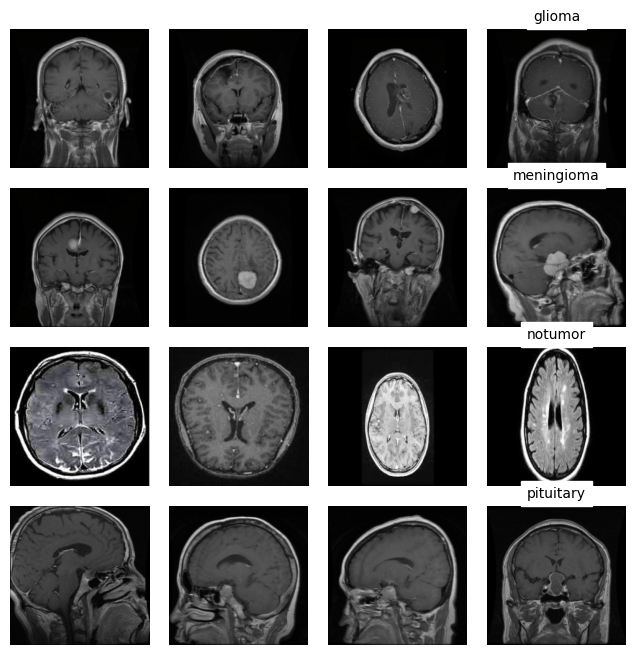

In [ ]:
#plotting the images
fig = plt.figure(figsize=(12, 8))
grid = ImageGrid(fig, 111, nrows_ncols=(IMAGE_PER_CATEGORY, NUM_OF_CATEGORIES), axes_pad=0.2)

i = 0
for col, category in enumerate(CATEGORIES):
    for row in range(IMAGE_PER_CATEGORY):
        ax = grid[i]
        img_tensor = category_images[category][row]
        img = img_tensor.numpy().transpose((1, 2, 0))
        img = (img * std + mean).clip(0, 1)
        ax.imshow(img)
        ax.axis('off')
        if row == IMAGE_PER_CATEGORY - 1:
            ax.set_title(category, fontsize=10, backgroundcolor='white')
        i += 1

plt.show()

In [ ]:
# Define the number of output classes and load the pre-trained GoogLeNet model
num_classes = len(train_dataset.classes)
model = models.googlenet(pretrained=True)

c:\Users\ronjd\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ronjd\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Replace the final fully connected layer to match the number of output classes in our dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# Training loop for the model

# Set the number of training epochs
num_epochs = 10

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for training batches
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for inputs, labels in progress_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()           # Clear gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update weights

        running_loss += loss.item()
        _, predicted = outputs.max(1)   
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Calculate batch accuracy
        batch_acc = 100 * predicted.eq(labels).sum().item() / labels.size(0)

        
        progress_bar.set_postfix(loss=loss.item(), batch_acc=f"{batch_acc:.2f}%")

    # Calculate training accuracy for the epoch
    train_acc = 100 * correct / total

    # Validation phase after each epoch
    model.eval()  
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            _, val_preds = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_preds.eq(val_labels).sum().item()

    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Val Acc={val_acc:.2f}%")




Epoch 1: 100%|██████████| 304/304 [01:23<00:00,  3.65it/s, batch_acc=100.00%, loss=0.0163] 


Epoch 1: Train Acc=96.29%, Val Acc=96.85%


Epoch 2: 100%|██████████| 304/304 [00:27<00:00, 10.98it/s, batch_acc=100.00%, loss=0.0204] 


Epoch 2: Train Acc=98.21%, Val Acc=98.02%


Epoch 3: 100%|██████████| 304/304 [00:27<00:00, 11.08it/s, batch_acc=100.00%, loss=0.00182]


Epoch 3: Train Acc=99.32%, Val Acc=97.67%


Epoch 4: 100%|██████████| 304/304 [00:27<00:00, 11.12it/s, batch_acc=100.00%, loss=0.0408]  


Epoch 4: Train Acc=99.51%, Val Acc=97.90%


Epoch 5: 100%|██████████| 304/304 [00:29<00:00, 10.45it/s, batch_acc=100.00%, loss=0.0146]  


Epoch 5: Train Acc=99.49%, Val Acc=98.72%


Epoch 6: 100%|██████████| 304/304 [00:31<00:00,  9.74it/s, batch_acc=100.00%, loss=0.0456]  


Epoch 6: Train Acc=99.49%, Val Acc=98.02%


Epoch 7: 100%|██████████| 304/304 [00:27<00:00, 11.10it/s, batch_acc=100.00%, loss=0.000967]


Epoch 7: Train Acc=99.65%, Val Acc=98.25%


Epoch 8: 100%|██████████| 304/304 [00:27<00:00, 11.02it/s, batch_acc=100.00%, loss=0.00443] 


Epoch 8: Train Acc=99.67%, Val Acc=97.55%


Epoch 9: 100%|██████████| 304/304 [00:27<00:00, 11.08it/s, batch_acc=100.00%, loss=0.0126]  


Epoch 9: Train Acc=99.73%, Val Acc=97.55%


Epoch 10: 100%|██████████| 304/304 [00:27<00:00, 11.05it/s, batch_acc=100.00%, loss=0.00458] 


Epoch 10: Train Acc=99.57%, Val Acc=97.55%


In [13]:
# Final Test Accuracy
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_preds = test_outputs.max(1)
        test_total += test_labels.size(0)
        test_correct += test_preds.eq(test_labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"Final Test Accuracy:        {test_acc:.2f}%")

Final Test Accuracy:        98.02%


In [ ]:
# Save the trained model weights to a file
torch.save(model.state_dict(), "googlenet_weights.pth")
